# Use Case 2: Semantic Search with Text Embeddings


### imports

In [1]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# Run the installation commands
!pip install faiss-cpu
!pip install sentence-transformers
!pip install openai
!pip install gradio
!pip install tiktoken

# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [2]:
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric

import matplotlib.pyplot as plt
import matplotlib as mpl

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### load data

In [3]:

# Corrected code to download the dataset
!wget -nc https://raw.githubusercontent.com/Tuchsanai/AIMaster-seagate-training-2024/main/Dataset/resumes/resumes_train.csv

!wget -nc https://raw.githubusercontent.com/Tuchsanai/AIMaster-seagate-training-2024/main/Dataset/resumes/resumes_test.csv

File ‘resumes_train.csv’ already there; not retrieving.

File ‘resumes_test.csv’ already there; not retrieving.



In [4]:
df_resume = pd.read_csv('resumes_train.csv')
df_resume['role'][df_resume['role'].iloc[-1] == df_resume['role']] = "Other" # relabel random role as "other"
df_resume.head()

,resume,role
0,### John Doe\n\n---\n\n#### Summary\nDetail-or...,Data Scientist
1,Creating a resume for a Data Scientist based o...,Data Scientist
2,Creating a resume for a Data Scientist...\n\n-...,Data Scientist
3,Creating a resume for a Data Scientist based o...,Data Scientist
4,## John Doe\n\n---\n\n### Summary:\nData Scien...,Data Scientist


### generate embeddings

In [5]:
# import pre-trained model (full list: https://www.sbert.net/docs/pretrained_models.html)
model = SentenceTransformer("all-MiniLM-L6-v2",)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:

# embed vectors
embedding_arr = model.encode(df_resume['resume'])

# Calculate the L2 norm for each vector
embedding_arr =  embedding_arr/np.linalg.norm(embedding_arr, axis=1, keepdims=True)


embedding_arr.shape

(100, 384)

### Visualize Embeddings

#### PCA

In [7]:
# apply PCA to embeddings
pca = PCA(n_components=2).fit(embedding_arr)
print(pca.explained_variance_ratio_)

[0.20212623 0.12736866]


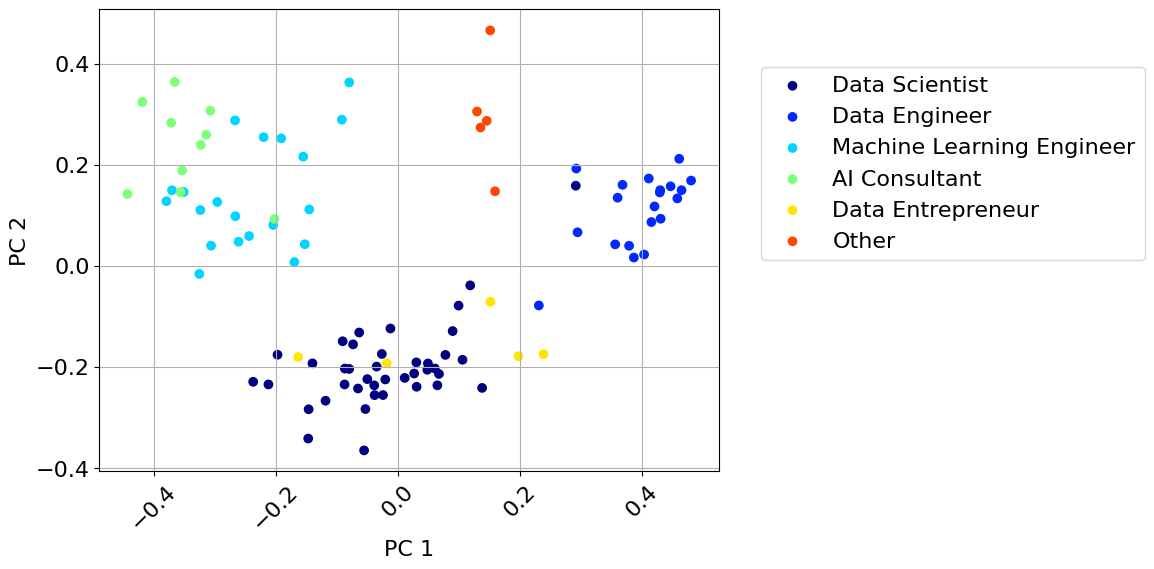

In [8]:
# plot data along PCA components
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for role in df_resume['role'].unique():
    idx = np.where(df_resume['role']==role)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=role)
    c = c + 1/len(df_resume['role'].unique())

plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### Semantic Search

In [9]:
import faiss

# Create and populate the Faiss index
d = embedding_arr.shape[1]  # Dimension of the embeddings

index = faiss.IndexFlatL2(d)
index.reset()

print("Number of vectors in the index: ", index.ntotal)
print("number of dimension = ", d)

Number of vectors in the index:  0
number of dimension =  384


In [10]:
# clear the index
index.reset()
# add the embedding vector to the index
index.add(embedding_arr)
print("Number of vectors in the index: ", index.ntotal)

Number of vectors in the index:  100


# Perform a Search with a Query

In [11]:
# Perform a search
def search_text(query, k=5):
    query_embedding = model.encode(query).reshape(1, -1)

    # norทalize the query embedding
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)
    distances, indices = index.search(query_embedding, k)

    return distances[0], indices[0], query_embedding


In [27]:
#query = "I need someone to build out my data infrastructure"
#query = "Co-founder for marketing analytics consultancy"
# query = "Project manager for AI feature development"
query   = "need machine learning"
#query = "Data Engineer with Apache Airflow experience"


distances, top_k_indices, query_embedding  = search_text(query, k=5)

In [28]:
top_k_indices

array([72, 69, 61, 60, 74])

In [29]:
distances

array([0.99098575, 1.0246078 , 1.0250981 , 1.0324334 , 1.0333025 ],
      dtype=float32)

In [30]:
print("Query:", query)
print("====================================")

for i, idx in enumerate(top_k_indices):
    if idx < 0:
        continue
    print(f"Rank {i+1}:")
    print("class = ",df_resume.loc[idx, "role"])
    print("distance = ", distances[i])
    print(df_resume.loc[idx, "resume"])
    print("====================================")

Query: need machine learning
Rank 1:
class =  Machine Learning Engineer
distance =  0.99098575
**Name:** Jane Smith

**Summary:**
Experienced Machine Learning Engineer with a strong background in developing and implementing machine learning algorithms. Skilled in data analysis, model evaluation, and deployment of predictive models. Proficient in programming languages such as Python and R, with a deep understanding of statistical modeling and deep learning techniques.

**Professional Experience:**
- Machine Learning Engineer at Tech Solutions Inc.
  - Developed machine learning models to improve customer satisfaction by 20%.
  - Implemented neural networks for image recognition tasks, reducing error rates by 15%.
  - Collaborated with cross-functional teams to integrate predictive models into existing software systems.
  
- Data Scientist at Data Analytics Co.
  - Conducted exploratory data analysis to identify key trends and patterns in customer behavior.
  - Built and optimized recomm

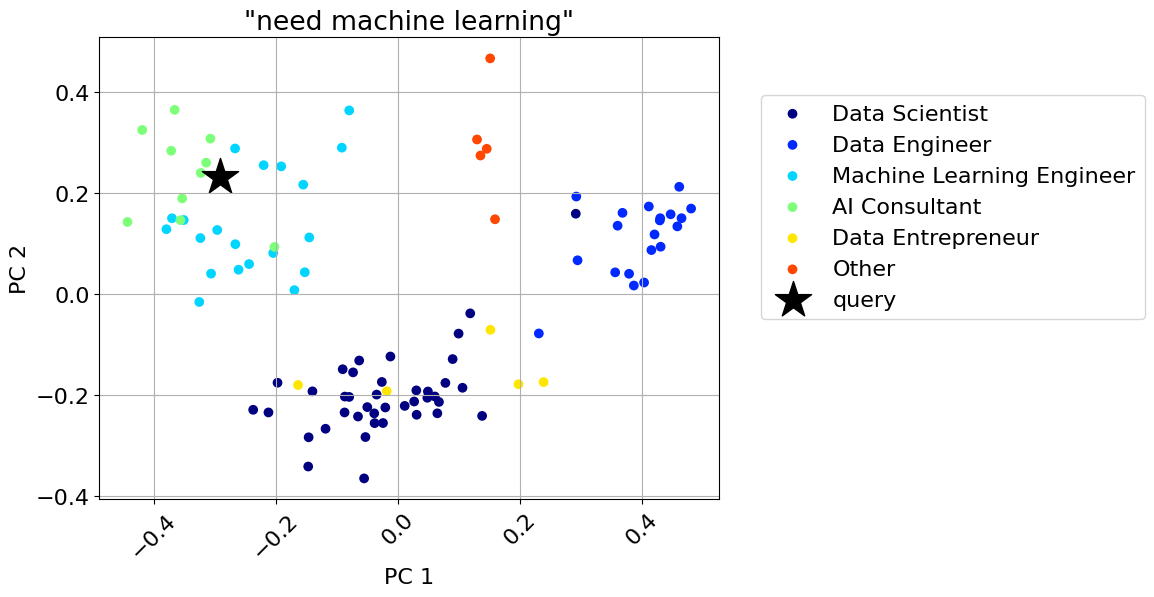

In [31]:



query_pca = pca.transform(query_embedding.reshape(1, -1))[0]

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for role in df_resume['role'].unique():
    idx = np.where(df_resume['role']==role)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=role)
    c = c + 1/len(df_resume['role'].unique())

plt.scatter(query_pca[0], query_pca[1], c='k', marker='*', s=750, label='query')

plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('"' + query + '"')
plt.show()